[585.  617.5 650.  682.5 715. ] nm
[643.5 650.  656.5] nm


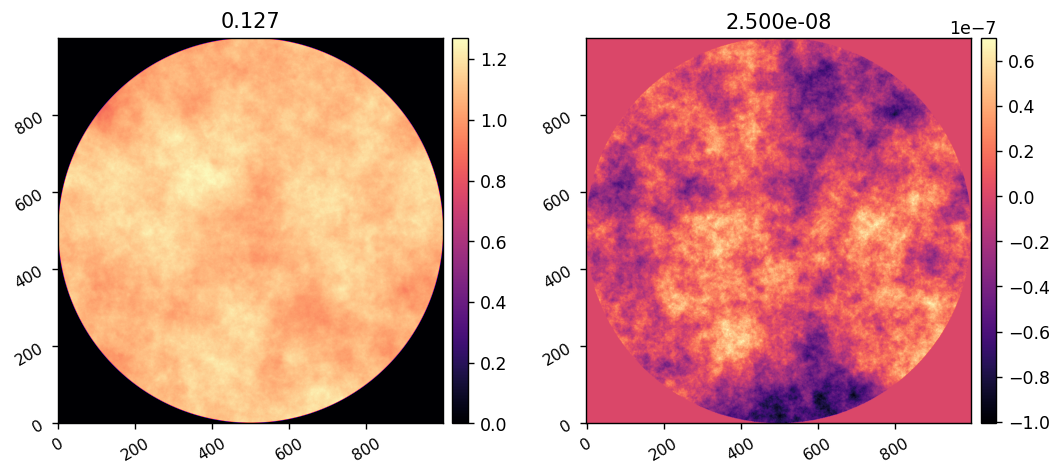

array(2.5e-08)

In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Circle
import copy
from importlib import reload

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import ray

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as scoob
import scoobpsf.parascoob as parascoob
import scoobpsf.dm as dm

import lina

N_llowfsc_waves = 5
bw = 0.2
wavelength_c = 650*u.nm
llowfsc_waves = np.linspace(wavelength_c*(1 - bw/2), wavelength_c*(1 + bw/2), N_llowfsc_waves)
print(llowfsc_waves)

N_coro_waves = 3
bw = 0.02
wavelength_c = 650*u.nm
coro_waves = np.linspace(wavelength_c*(1 - bw/2), wavelength_c*(1 + bw/2), N_coro_waves)
print(coro_waves)

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=npix, oversample=1,
                                wavelength=wavelength_c,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength_c.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


5.33773312815364e-15 sr


<Quantity [2.58652891e+09, 2.56468938e+09, 2.58180762e+09] ph / (s m2)>

5.33773312815364e-15 sr


<Quantity [1.28567186e+10, 1.29793866e+10, 1.29820671e+10, 1.28714597e+10,
           1.26904454e+10] ph / (s m2)>

<Quantity 7.73302592e+09 ph / (s m2)>

<Quantity 6.43800775e+10 ph / (s m2)>

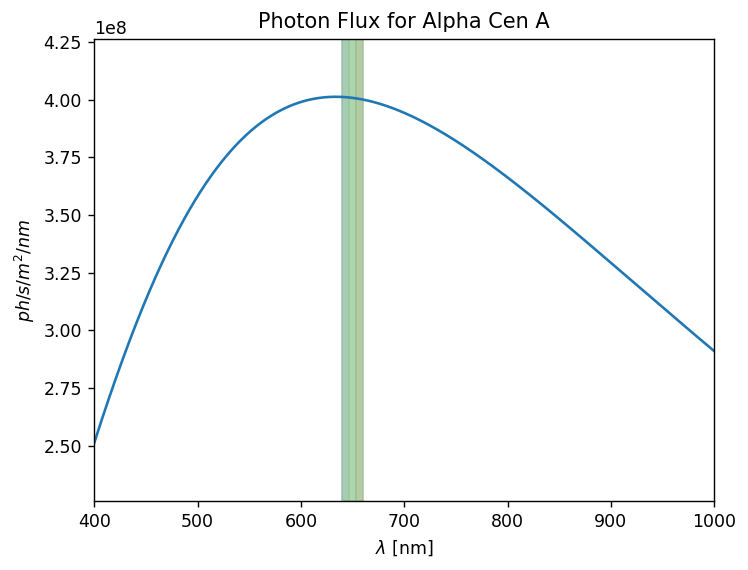

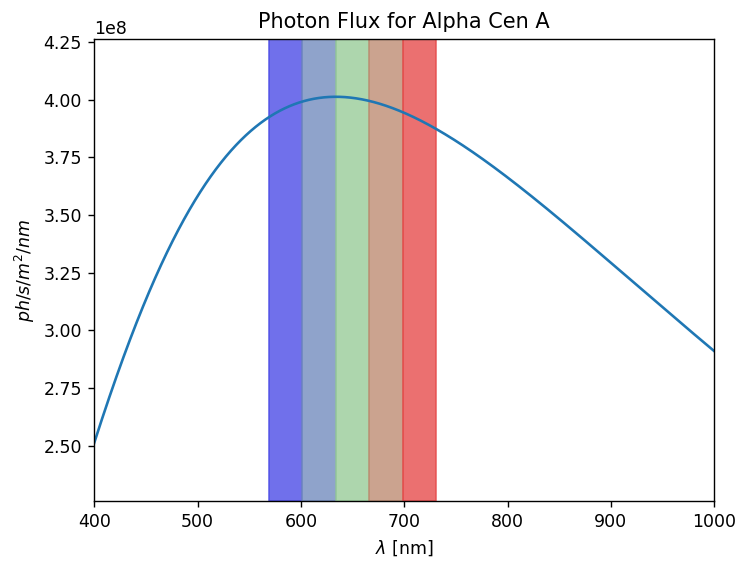

In [2]:
import scoobpsf.source_flux as flux
from astropy.constants import R_sun
distance = 4.344*u.lightyear
radius = 1.2175*R_sun
temp = 5790*u.Kelvin

alpha_cen_a = flux.SOURCE(coro_waves, distance, temp, diameter=2*radius, name='Alpha Cen A')
alpha_cen_a.plot_spectrum_ph()
coro_wave_fluxes = alpha_cen_a.calc_fluxes()
display(coro_wave_fluxes)

alpha_cen_a = flux.SOURCE(llowfsc_waves, distance, temp, diameter=2*radius, name='Alpha Cen A')
alpha_cen_a.plot_spectrum_ph()
llowfsc_wave_fluxes = alpha_cen_a.calc_fluxes()
display(llowfsc_wave_fluxes)

total_coro_flux = np.sum(coro_wave_fluxes)
total_llowfsc_flux = np.sum(llowfsc_wave_fluxes)
display(total_coro_flux, total_llowfsc_flux)

# Check that the photon flux is conserved thorughout propagation with a monochromatic model.

Expected Flux for a 2.4m aperture: 1.170e+10 ph / s
Flux in the model aperture: 1.169e+10
Expected Flux through the Lyot Stop: 9.788e+09
Measured flux of the model PSF: 9.753e+09


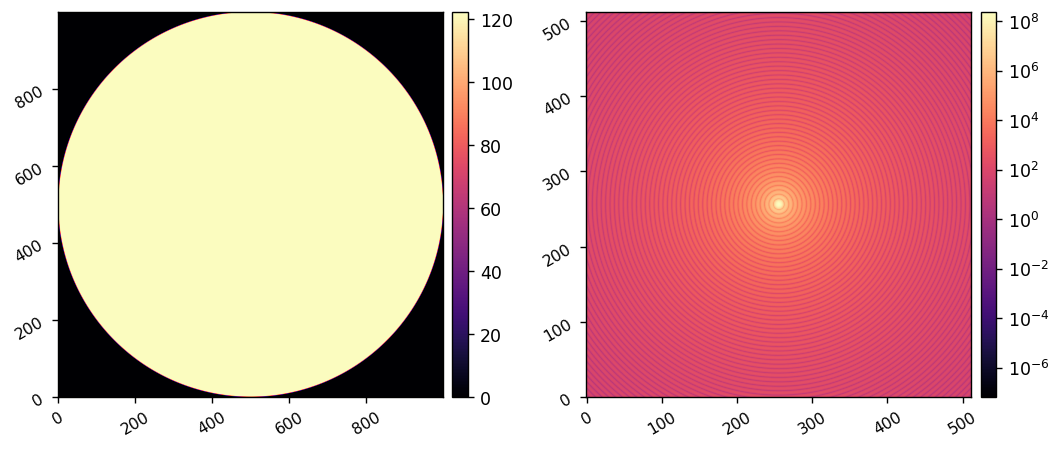

In [14]:
reload(scoob)
mono_model = scoob.CORO(entrance_flux=coro_wave_fluxes[0])
mono_model.npsf = 512
psf = mono_model.snap()
print(f'Expected Flux for a 2.4m aperture: {coro_wave_fluxes[0]*np.pi*mono_model.total_pupil_diam**2/4:.3e}')
print(f'Flux in the model aperture: {xp.sum(xp.square(mono_model.APERTURE)):.3e}')
print(f'Expected Flux through the Lyot Stop: {xp.sum(xp.square(mono_model.APERTURE)*mono_model.lyot_ratio**2):.3e}')
print(f'Measured flux of the model PSF: {xp.sum(psf):.3e}')
imshow2(mono_model.APERTURE, psf, lognorm2=True)


# Now do the same check for a broadband model

In [15]:
ray_scoob = ray.remote(scoob.CORO)

llowfsc_actors = []
for i in range(N_llowfsc_waves):
    params = {
        'wavelength':llowfsc_waves[i],
        'entrance_flux':llowfsc_wave_fluxes[i],
    }
    llowfsc_actors.append(ray_scoob.options(num_cpus=4, num_gpus=1/10).remote(**params))

coro_actors = []
for i in range(N_coro_waves):
    params = {
        'wavelength':coro_waves[i],
        'entrance_flux':coro_wave_fluxes[i],
    }
    coro_actors.append(ray_scoob.options(num_cpus=4, num_gpus=1/10).remote(**params))


2024-05-18 18:38:11,315	INFO worker.py:1636 -- Started a local Ray instance.


(CORO pid=2375471) Oversampling > 2x suggested for reliable results in Fresnel propagation.


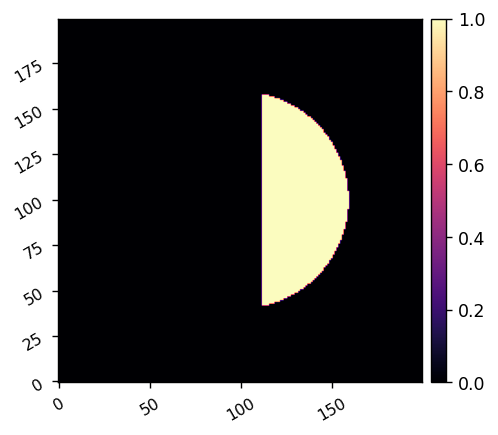

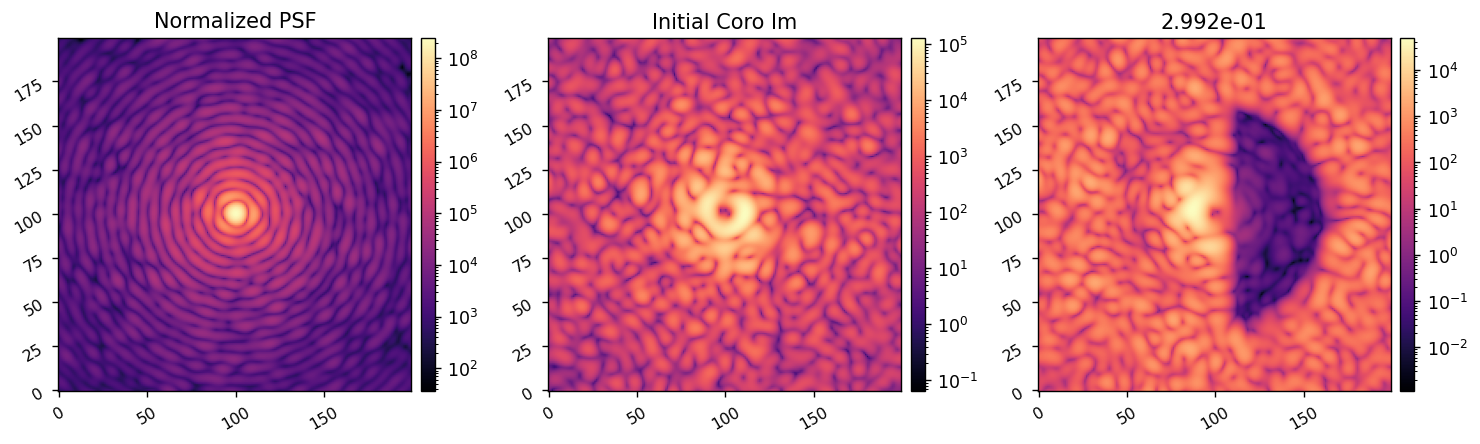

In [16]:
reload(parascoob)
coro_model = parascoob.ParallelizedScoob(actors=coro_actors)
coro_model.set_actor_attr('WFE', WFE)
coro_model.zero_dm()

coro_model.set_actor_attr('use_fpm', False)
# coro_model.set_actor_attr('Imax_ref', xp.max(coro_model.snap()))
ref_psf = coro_model.snap()

coro_model.set_actor_attr('use_fpm', True)
ref_coro_im = coro_model.snap()

dark_hole_command = xp.array(fits.getdata('dark_hole_command.fits'))
coro_model.dm_ref = dark_hole_command
coro_model.reset_dm()
dark_coro_im = coro_model.snap()

control_mask = lina.utils.create_annular_focal_plane_mask(coro_model, 2, 10, 2, plot=True)
mean_contrast = xp.mean(dark_coro_im[control_mask])

imshow3(ref_psf, ref_coro_im, dark_coro_im, 'Normalized PSF', 'Initial Coro Im', f'{mean_contrast:.3e}', lognorm=True)

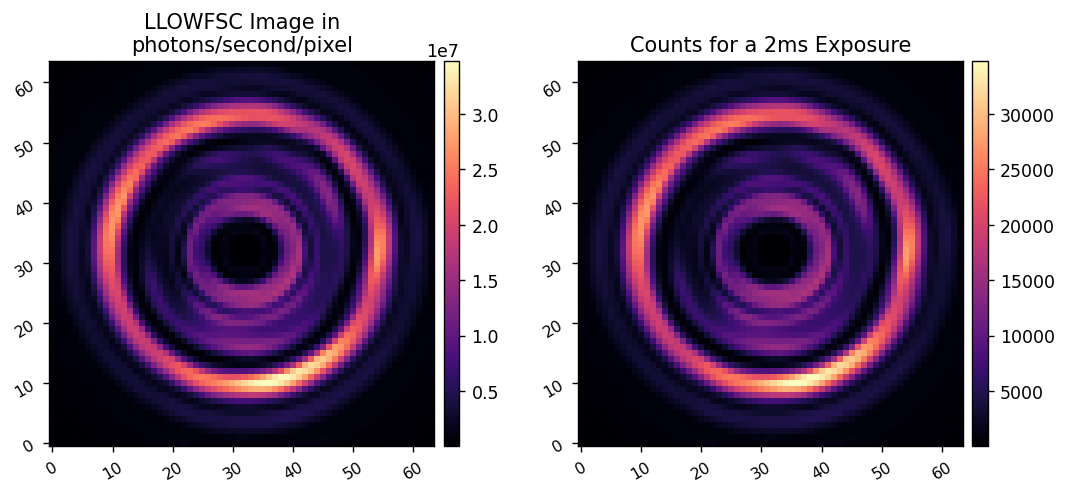

In [23]:
reload(parascoob)
model = parascoob.ParallelizedScoob(actors=llowfsc_actors)
model.set_actor_attr('WFE', WFE)
model.set_actor_attr('use_fpm', True)
model.dm_ref = dark_hole_command
model.reset_dm()
model.use_llowfsc()

llowfsc_im = model.snap()

exp_time = 0.001
imshow2(llowfsc_im, llowfsc_im*exp_time, 
        'LLOWFSC Image in\nphotons/second/pixel', 
        'Counts for a 2ms Exposure')
